In [1]:
##################################
# Download, merging and annotation
##################################

In [2]:
import GEOparse
import pandas as pd
import numpy as np


# для визуализации распределения семплов в пространстве признаков
def plot_mds(X, target, colors = ['green', 'red'], labels = ['CTRL', 'HCM']):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    mds = MDS(2,random_state=0)
    X_2d = mds.fit_transform(X_scaled)
    
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    for i in np.unique(target):
        subset = X_2d[target == i]
        x = [row[0] for row in subset]
        y = [row[1] for row in subset]
        plt.scatter(x, y, c=colors[i], label = labels[i])
    plt.legend()
    plt.show()

In [3]:
dataset_name = "GSE36961" # набор на 145 семплов

gse = GEOparse.get_GEO(dataset_name)
data_train = gse.pivot_samples('VALUE')

# вытаскиваем лейблы семплов

experiments = {}
for i, (idx, row) in enumerate(gse.phenotype_data.iterrows()):
    tmp = {}
    tmp["Experiment"] = idx
    tmp['platform_id'] = row['platform_id']
    tmp['status'] = 'HCM' if 'HCM' in row['source_name_ch1'] else 'CTRL'
    experiments[i] = tmp
experiments = pd.DataFrame(experiments).T

gsm_to_stat = dict(zip(experiments['Experiment'], experiments['status']))
data_train.columns = [gsm_to_stat[i] for i in data_train.columns]

16-Aug-2021 21:49:45 DEBUG utils - Directory ./ already exists. Skipping.
16-Aug-2021 21:49:45 INFO GEOparse - File already exist: using local version.
16-Aug-2021 21:49:45 INFO GEOparse - Parsing ./GSE36961_family.soft.gz: 
16-Aug-2021 21:49:45 DEBUG GEOparse - DATABASE: GeoMiame
16-Aug-2021 21:49:45 DEBUG GEOparse - SERIES: GSE36961
16-Aug-2021 21:49:45 DEBUG GEOparse - PLATFORM: GPL15389
16-Aug-2021 21:49:45 DEBUG GEOparse - SAMPLE: GSM907203
16-Aug-2021 21:49:45 DEBUG GEOparse - SAMPLE: GSM907204
16-Aug-2021 21:49:45 DEBUG GEOparse - SAMPLE: GSM907205
16-Aug-2021 21:49:45 DEBUG GEOparse - SAMPLE: GSM907206
16-Aug-2021 21:49:45 DEBUG GEOparse - SAMPLE: GSM907207
16-Aug-2021 21:49:45 DEBUG GEOparse - SAMPLE: GSM907208
16-Aug-2021 21:49:45 DEBUG GEOparse - SAMPLE: GSM907209
16-Aug-2021 21:49:45 DEBUG GEOparse - SAMPLE: GSM907210
16-Aug-2021 21:49:46 DEBUG GEOparse - SAMPLE: GSM907211
16-Aug-2021 21:49:46 DEBUG GEOparse - SAMPLE: GSM907212
16-Aug-2021 21:49:46 DEBUG GEOparse - SAMPLE: 

16-Aug-2021 21:49:55 DEBUG GEOparse - SAMPLE: GSM907343
16-Aug-2021 21:49:55 DEBUG GEOparse - SAMPLE: GSM907344
16-Aug-2021 21:49:55 DEBUG GEOparse - SAMPLE: GSM907345
16-Aug-2021 21:49:55 DEBUG GEOparse - SAMPLE: GSM907346
16-Aug-2021 21:49:55 DEBUG GEOparse - SAMPLE: GSM907347


In [4]:
dataset_name = "GSE1145"

gse = GEOparse.get_GEO(dataset_name)
data_test = gse.pivot_samples('VALUE')
data_test.head()

# вытаскиваем лейблы семплов

def status_extr(row):
    if 'N' in row['title']:
        return 'CTRL'
    elif 'hypertrophic cardiomyopathy' in row['description'].split('Keywords = ')[1]:
        return 'HCM'
    else:
        return 9999

experiments = {}
for i, (idx, row) in enumerate(gse.phenotype_data.iterrows()):
    tmp = {}
    tmp['title'] = row['title'][3:]
    tmp["Experiment"] = idx
    tmp['platform_id'] = row['platform_id']
    tmp['description'] = row['description'].split('Keywords = ')[1]
    tmp['status'] = status_extr(row)
    experiments[i] = tmp
experiments = pd.DataFrame(experiments).T

tmp_exp = experiments[experiments['status'] != 9999][experiments['platform_id'] == 'GPL570']

data_test = data_test.filter(tmp_exp['Experiment'])    #отбираем ту часть эксперимента, которая нам нужна, сделанная на GPL570. 
                                                    #Другая часть - исследование экспрессии микроРНК
gsm_to_stat = dict(zip(tmp_exp['Experiment'], tmp_exp['status']))
data_test.columns = [gsm_to_stat[i] for i in data_test.columns]

16-Aug-2021 21:49:57 DEBUG utils - Directory ./ already exists. Skipping.
16-Aug-2021 21:49:57 INFO GEOparse - File already exist: using local version.
16-Aug-2021 21:49:57 INFO GEOparse - Parsing ./GSE1145_family.soft.gz: 
16-Aug-2021 21:49:57 DEBUG GEOparse - DATABASE: GeoMiame
16-Aug-2021 21:49:57 DEBUG GEOparse - SERIES: GSE1145
16-Aug-2021 21:49:57 DEBUG GEOparse - PLATFORM: GPL570
/opt/anaconda3/lib/python3.7/site-packages/GEOparse/GEOparse.py:104: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return parse_GSE(filepath)
16-Aug-2021 21:49:59 DEBUG GEOparse - PLATFORM: GPL8300
16-Aug-2021 21:49:59 DEBUG GEOparse - SAMPLE: GSM18422
16-Aug-2021 21:49:59 DEBUG GEOparse - SAMPLE: GSM18423
16-Aug-2021 21:49:59 DEBUG GEOparse - SAMPLE: GSM18424
16-Aug-2021 21:49:59 DEBUG GEOparse - SAMPLE: GSM18425
16-Aug-2021 21:49:59 DEBUG GEOparse - SAMPLE: GSM18426
16-Aug-2021 21:50:00 DEBUG GEOparse - SAMPLE: GSM18427
16-Aug-2021 21:50:00 DEBUG

In [5]:
# data_test в качестве индексов содержит probeset id, здесь перегоняем их в Gene Symbol 

data_test['index'] = data_test.index

# annotate with GPL
data_test = data_test.reset_index().merge(gse.gpls['GPL570'].table[["ID", "Gene Symbol"]],
                                left_on='index', right_on="ID").set_index('index')
del data_test["ID"]
# remove probes without ENTREZ
data_test = data_test.dropna(subset=['Gene Symbol'])
# remove probes with more than one gene assigned
data_test = data_test[~data_test['Gene Symbol'].str.contains("///")]
# for each gene average LFC over probes
data_test = data_test.groupby('Gene Symbol').median()

In [6]:
print('test:', data_test.shape)
print('train:', data_train.shape)

# отбираем те гены, которые есть в обоих наборах
set_test = set(data_test.index)
gene_universe = set_test.intersection(data_train.index)

data_train = data_train.filter(gene_universe, axis=0)
data_test = data_test.filter(gene_universe, axis=0)

print()
print('test:', data_test.shape)
print('train:', data_train.shape)

test: (21655, 16)
train: (37846, 145)

test: (14830, 16)
train: (14830, 145)


In [7]:
class Data(object): 
    def __init__(self):
        pass
    
Data.X = Data()
Data.X.train = data_train
Data.X.test = data_test
Data.y = Data()
Data.y.train = list(map(int, Data.X.train.columns == 'HCM'))
Data.y.test = list(map(int, Data.X.test.columns == 'HCM'))

In [49]:
#################################
# Feature selection
#################################

In [ ]:
"""
Главная идея:

Выборка маленькая, поэтому не будем избегать влияния случайности, например фиксируя random_state, а будем пытаться эту случайность оседлать.

Как будем отбирать фичи?

1) Фичи будем отбирать на основе лог.регрессии.
        а) подберем коэффициент L1-регуляризации
        б) будем обучать 1000 моделей на бутстрепленных из X_train данных
        в) фичи, которые попали в модель, которая хоть как-то работает (coef > 0) хоть в одной работающей (roc-auc > 0.7) моделе, будем сохранять в словарик

2) Отобранные фичи упорядочим по их ценности, за которую примем произведение roc-auc модели, из которой пришла фича, coef и количества моделей, в которые фича была включена.
                                            идея: чем в большее число хорошо работающих моделей включается фича - тем она ценнее

3) Финально выберем какую-то долю из тех фичей, которые входят в топ-20 фичей упорядоченного списка

"""

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, linear_model, model_selection
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap
import random
from sklearn.manifold import MDS
from collections import Counter
from random import choices
from itertools import compress

roc_auc_scorer = metrics.make_scorer(metrics.roc_auc_score)
scaler = StandardScaler()

In [9]:
# train test split and scaling

X_train, X_test, y_train, y_test = train_test_split(Data.X.train.transpose(), Data.y.train, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# возвращаем имена фичей
X_train = pd.DataFrame(X_train, columns=Data.X.train.index)
X_test = pd.DataFrame(X_test, columns=Data.X.train.index)

In [10]:
C = np.array([0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01])

0
1
2
3
4
5
6
7
8
9


[<matplotlib.lines.Line2D at 0x7fcb00b3a350>]

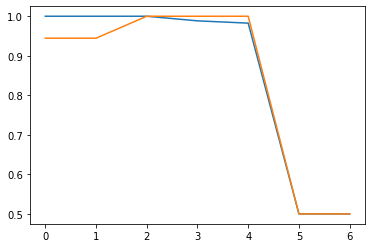

In [64]:
# Подбираем коэффициент регуляризации. Выбираем тот, после которого всё качество идет по п*зде

result_df_train = pd.DataFrame()
result_df_test = pd.DataFrame()


# 10 раз шатаем модель по разным random_state, потом усредняем по смотрим на результат по коэффициентам

for a in range(0,10):
    print(a)
    random_state = random.randint(1,100)
    roc_auc_train = list()
    roc_auc_test = list()
    for i in C:
        linear_regressor = linear_model.LogisticRegression(penalty='l1', C=i, solver='liblinear', random_state=random_state)
        linear_regressor.fit(X_train, y_train)
        roc_auc_train.append(metrics.roc_auc_score(y_train, linear_regressor.predict(X_train)))
        roc_auc_test.append(metrics.roc_auc_score(y_test, linear_regressor.predict(X_test)))
    result_df_train[a] = roc_auc_train
    result_df_test[a] = roc_auc_test

plt.plot(result_df_train.apply(np.mean, axis=1))
plt.plot(result_df_test.apply(np.mean, axis=1))

In [11]:
class FeatureExtraction(object):
    
    """
    Класс для экстракции фичей. Главная идея не фиксировать случайность, а оседлать её :)
    
    """
    
    
    def __init__(self, ):
        pass
        
    def fit(self, n_iter, X_train, y_train, X_test, y_test, C=0.03):
        
        """
        Будем n_iter раз бутстрепить сбалансированную train выборку из X_train.
        Обучаем лог.рег. с L1-решуляризацией, с коэффициентом как мы отобрали выше.
        Тестим на X_test, значение добавляем в roc_auc_list
        
        Если на X_test модель работает круче 0.7, то: 
            1) ненулевые фичи модели добавляем в словарик отобранных фичей feature_dict
            2) обновляем число фичей в перменной len_best_feature = len(feature_dict.keys())
        Если нет, то:
            3) дублируем последнее значение в len_best_feature, т.к. число фичей не изменилось
        """
        
        len_best_feature = [0] # заводим лист, в котором будем отслеживать изменение количества фичей
        roc_auc_list = list() # аналогично, отслеживаем как меняется roc-auc, так для интереса
        feature_dict = dict() # # словарь "ген: log.reg.coef"
        
        for i in range(0, n_iter):

            random_state = random.randint(0, 500) # явным образом шатаем рандомстейт

            # чтобы получить сбаланнсированную выборку, бутстрепим отдельно семплы из контроля и из опыта

            mask = np.array(y_train) == 0

            CTRL_rows = list(compress(range(0, len(mask)), mask))
            HCM_rows = list(compress(range(0, len(mask)), mask == False))

            _HCM_rows = choices(HCM_rows, k=50) # бутстрепим номера строк из группы больных
            _CTRL_rows = choices(CTRL_rows, k=50) # бутстрепим номера строк из группы здоровых

            # объединяем это всё дело обратно

            _X_train = pd.DataFrame(X_train).iloc[_HCM_rows + _CTRL_rows,:]
            _y_train = np.array(y_train)[_HCM_rows + _CTRL_rows]

            # обучаем лог.рег. с ранее отобранным коэффициентом регуляризации

            linear_regressor = linear_model.LogisticRegression(penalty='l1', C=C, solver='liblinear', 
                                                               random_state=random_state)
            linear_regressor.fit(_X_train, _y_train)

            # тестим

            roc_auc = metrics.roc_auc_score(y_score=linear_regressor.predict(X_test), y_true=y_test)
            roc_auc_list.append(roc_auc)

            # далее отбираем фичи из моделей, которые хоть как-то работают (roc_auc > 0.7)

            if roc_auc > 0.7:
                # отбираем смысловые фичи
                mask = linear_regressor.coef_ != 0 
                genes = X_train.columns[mask[0]]
                values = linear_regressor.coef_[mask]

                _feature_dict = dict(zip(genes, abs(values)*roc_auc)) #делаем временный словарь "ген: его ценность"

                # обнавляем глобальный словарь фичей
                for gene, values in _feature_dict.items():
                    if gene in feature_dict:
                        feature_dict[gene].append(values)
                    else:
                        feature_dict[gene] = [values]

                len_best_feature.append(len(feature_dict.keys()))
            
            else:
                # если модель была говёной, то просто дублируем предыдущее значение. Ну, число фичей то не изменилось :)
                len_best_feature.append(len_best_feature[-1]) 
        
        self.len_best_feature = len_best_feature
        self.feature_dict = feature_dict
        self.roc_auc_list = roc_auc_list
    

In [146]:
fe = FeatureExtraction()

In [151]:
fe.fit(1000, X_train, y_train, X_test, y_test)

[<matplotlib.lines.Line2D at 0x7fcb04b54150>]

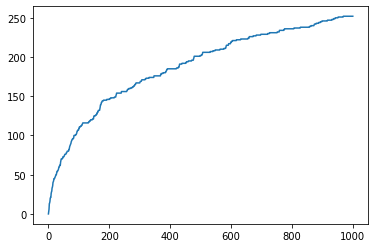

In [154]:
#посмотрим, как с каждой итерацией нарастают фичи

plt.plot(fe.len_best_feature)

[<matplotlib.lines.Line2D at 0x7fcb047b5590>]

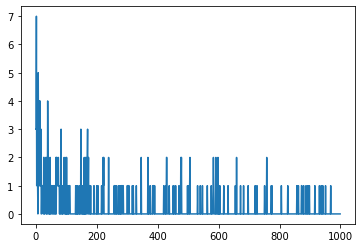

In [153]:
# посмотрим как выглядит производная, видно, что, в целом, после 300 итерации прирост фичей постоянный и монотонный, 
# по одной фиче за итерацию. Ну, и всё чаще встречаются нули, т.е. новых фичей не приростает
plt.plot(np.diff(fe.len_best_feature))

(array([244.,   7.,  10.,   1.,   2.,   1.,   1.,   1.,   0.,   1.]),
 array([  1. ,  64.1, 127.2, 190.3, 253.4, 316.5, 379.6, 442.7, 505.8,
        568.9, 632. ]),
 <a list of 10 Patch objects>)

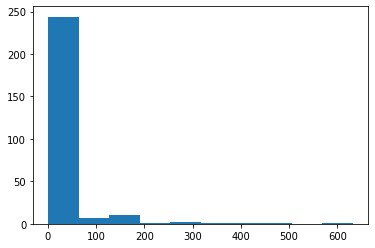

In [91]:
# а вот так выглядит распределение фичей по частоте их включения в модельки.
# больше 200 фичей включались только один раз, ну, очевидно, что это мусор.

feature_distr = list(map(lambda x: len(fe.feature_dict[x]), fe.feature_dict))
plt.hist(feature_distr)

In [12]:
"""
Идея: повторим экстракцию фичей 40 раз (вычислительно емко получается для ноутбучика), 
отсортируем каждый из получившихся наборов по важности фичей, найдем размер окна для отбора n-топ фичей, 
в котором состав фичей минимально изменяется от набора к набору. А потом отберем те фичи, которые всегда встречаются в окне этого размера.
"""

list_feature_dicts = list()
for i in range(0,40):
    fe = FeatureExtraction()
    fe.fit(300, 
           X_train, y_train, X_test, y_test)
    list_feature_dicts.append(fe.feature_dict)

In [13]:
lfd = list_feature_dicts

In [14]:
# удаляем фичи, которые были включены только в одну модель, как сказали выше - это мусор

for i in range(0, len(lfd)):
    d = lfd[i]
    lfd[i] = {k : v for k, v in d.items() if len(v)>1}

In [124]:
#сортируем фичи в порядке убывания их значимости
#значимость считаем как (число включений в моедль)*(roc_auc_модели)*(abs(coef_))

lfd_sort = list()
for d in lfd:
    lfd_sort.append(dict(sorted(d.items(), key=lambda item: len(item[1])*np.median(item[1]), reverse=True)))

In [125]:
"""
Идея:

Хотим выбрать топ n генов, который минимально изменяется от набора в lfd к набору (с точностью до перестановки). 
Очевидно 1 < n < минимального набора генов.

"""

result = list()

min_len = min(list(map(lambda x: len(x.keys()), lfd_sort))) # минимальная длина словаря feature_dict 

for yeld in range(1, min_len):
    
    similarity = np.zeros((20,20))
    
    for i in range(0,20):
        for j in range(0,20):
            one_set = set(list(lfd_sort[i].keys())[:yeld])
            two_set = set(list(lfd_sort[j].keys())[:yeld])
            sim = len(one_set.intersection(two_set))/yeld
            similarity[i,j] = sim
    
    result.append(np.mean(similarity))

[<matplotlib.lines.Line2D at 0x7fea36bb0490>]

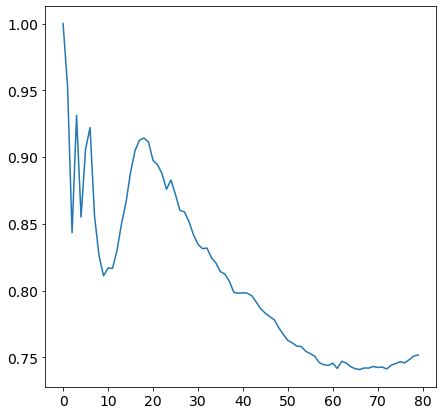

In [126]:
plt.plot(result)

"""
В окне до 20 фичей всё немного колабисит. Очевидно топовые фичи прыгают по позициям от 0 до 20. 
После 20 график стабильно падает, стало быть на следующих позициях уже становится всё больше и больше рандома.
Найдем точку перелома (она оказалась равна 18), и дальше будем оперировать окном этого размера.
"""

In [232]:
result[15:25] == max(result[15:25])

array([False, False, False,  True, False, False, False, False, False,
       False])

In [169]:
#отбираем гены, которые входят в топ 20 словарей
TOP = 18

top_20_gene_list = map(lambda x: list(x.keys())[:TOP], lfd_sort)

top_gene = set()
for i in top_20_gene_list:
    top_gene.update(i)

In [170]:
gene_weight = dict()
for gene in top_gene:
    value = sum(list(map(lambda x: gene in list(x.keys())[:TOP], lfd_sort)))/len(lfd_sort)
    gene_weight[gene] = value

(array([ 4.,  2.,  2.,  0.,  0.,  1.,  0.,  0.,  4., 13.]),
 array([0.025 , 0.1225, 0.22  , 0.3175, 0.415 , 0.5125, 0.61  , 0.7075,
        0.805 , 0.9025, 1.    ]),
 <a list of 10 Patch objects>)

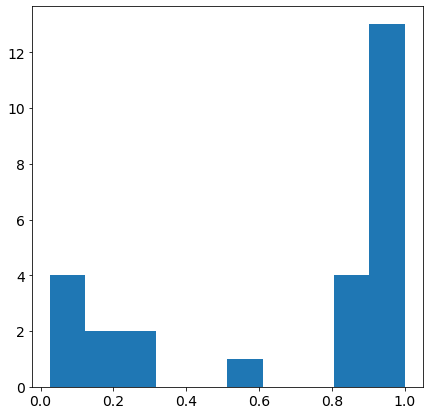

In [171]:
plt.hist(list(gene_weight.values()))

In [172]:
best_features = [k for k in gene_weight.keys() if gene_weight[k] > 0.95]

In [173]:
print(*best_features)

FCN3 MT1X PROS1 MYH6 CDC42EP4 ZFP36 PRKCD LYVE1 CEBPD MT1M RASD1 S1PR3


In [ ]:
#################################
# model train
#################################

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import Normalizer

# для визуализации распределения семплов в пространстве признаков
def plot_mds(X, target, colors = ['green', 'red'], labels = ['CTRL', 'HCM']):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    mds = MDS(2,random_state=0)
    X_2d = mds.fit_transform(X_scaled)
    
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    for i in np.unique(target):
        subset = X_2d[target == i]
        x = [row[0] for row in subset]
        y = [row[1] for row in subset]
        plt.scatter(x, y, c=colors[i], label = labels[i])
    plt.legend()
    plt.show()

scaler = StandardScaler()
Normalizer = Normalizer()

def StandartScaling(X):
    
    scaler = StandardScaler()
    """
    X - matrix, features in columns, samples in rows
    """
    
    colnames = X.columns 
    X = X.transpose()   # StandardScaler работает по столбцам, поэтому транспонируем, чтобы в столбцах оказались семплы
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X.transpose(), columns=colnames)
    return(X)

In [2]:
best_features = ['FCN3', 'MT1X', 'PROS1', 'MYH6', 'CDC42EP4', 'ZFP36', 'PRKCD', 'LYVE1', 'CEBPD', 'MT1M', 'RASD1', 'S1PR3']

X = pd.read_csv('./X_train.csv', index_col=0).transpose().filter(best_features, axis=1)
X_test_out = pd.read_csv('./X_test_out.csv', index_col=0).transpose().filter(best_features, axis=1)

y = list(pd.read_csv('./y_train.csv').iloc[:,1])
y_test_out = list(pd.read_csv('./y_test_out.csv').iloc[:,1])

print(X.shape, X_test_out.shape)

(145, 12) (16, 12)


In [3]:
X = Data.X.train.transpose().filter(best_features, axis=1)
X_test_out = Data.X.test.transpose().filter(best_features, axis=1)
y = Data.y.train
y_test_out = Data.y.test

NameError: name 'Data' is not defined

In [3]:
colnames = X.columns
X = StandartScaling(X)
X_test_out = StandartScaling(X_test_out)

#X = pd.DataFrame(Normalizer.fit_transform(X), columns=colnames)
#X_test_out = pd.DataFrame(Normalizer.fit_transform(X_test_out), columns=colnames)

print(X.shape, X_test_out.shape)

(145, 12) (16, 12)


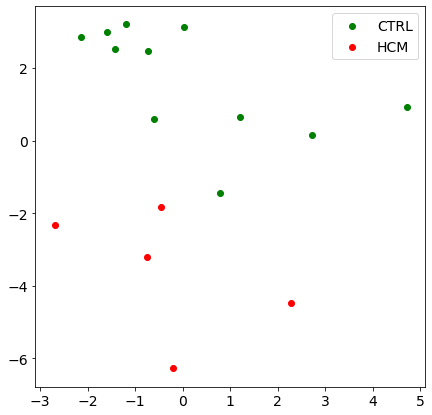

In [4]:
plot_mds(X_test_out, y_test_out)

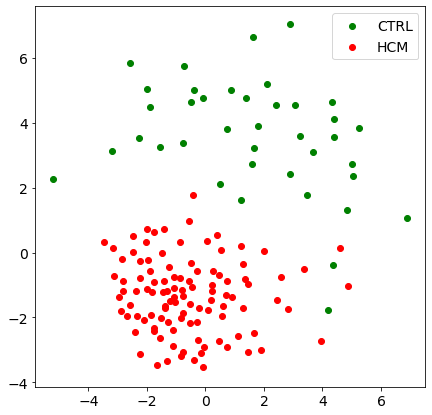

In [5]:
plot_mds(X, y)

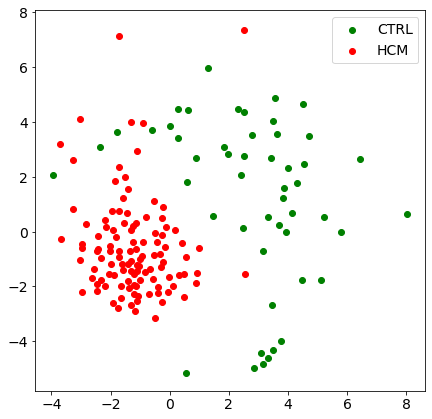

In [6]:
plot_mds(pd.concat([X, X_test_out]), y + y_test_out)

In [7]:
rf_params = {'random_state': 42, 'n_estimators': 3, 'max_samples': 0.5, 'max_features': 'auto', 
             'max_depth': 1, 'class_weight': 'balanced', 'bootstrap': 'True'}

estimators = [
    ('rf', make_pipeline(StandardScaler(),
                         RandomForestClassifier(**rf_params))),
    ('logreg', make_pipeline(StandardScaler(),
                             LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', 
                                                penalty='l2', C=0.05)))
     ]
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=LogisticRegression(penalty='l2', C=1), 
                         passthrough = False)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
clfStack = clf.fit(X_train, y_train)

print("train:", metrics.roc_auc_score(y_score=clfStack.predict(X_train), 
                                      y_true=y_train))
print('test_in:', metrics.roc_auc_score(y_score=clfStack.predict(X_test), 
                                           y_true=y_test))
print("test_out:", metrics.roc_auc_score(y_score=clfStack.predict(X_test_out), 
                                     y_true=y_test_out))

train: 0.9767441860465116
test_in: 0.975
test_out: 0.9545454545454545


In [10]:
linear_regressor = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', 
                                                penalty='l2', C=0.05)
linear_regressor.fit(X_train, y_train)
metrics.roc_auc_score(y_true=y_test_out, y_score=linear_regressor.predict(X_test_out))

0.8545454545454545

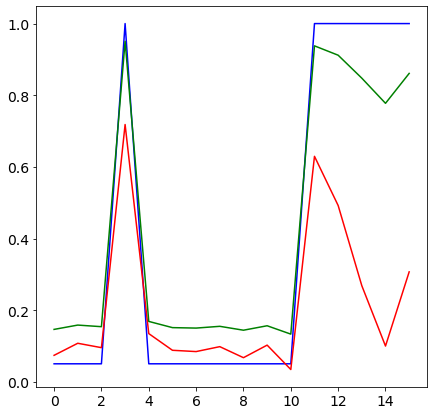

In [11]:
plt.plot(clf.estimators_[0].predict_proba(X_test_out)[:,1], 'blue')
plt.plot(clf.estimators_[1].predict_proba(X_test_out)[:,1], 'red')
plt.plot(clf.predict_proba(X_test_out)[:,1], 'green')